# Trajectory Analysis

This notebook generates trajectory visualization plots for detailed analysis of policy behavior.

**Features:**
- Runs `wandb_eval.py` via subprocess if trajectory data doesn't exist
- Multi-panel trajectory plots with phase annotations
- Break analysis by phase
- Selection confidence comparison
- Selection probability trajectories by phase

In [2]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import pickle
import subprocess
import os
import sys
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Union

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Method Tags - internal name -> wandb tag
METHOD_TAGS = {
    "Pose": "pose_perf-comp:2026-01-05_10:54",
    "Hybrid-Basic": "basic-hybrid_perf-comp:2026-01-05_10:54",
    "LCLoP": "LCLoP_perf-comp:2026-01-05_10:54",
}

# Method display settings
METHOD_COLORS = {
    "Pose": "#2ca02c",        # Green
    "Hybrid-Basic": "#ff7f0e", # Orange
    "LCLoP": "#1f77b4",       # Blue
}

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"

# Metrics for best policy selection
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"

# Trajectory Evaluation Configuration
WANDB_EVAL_SCRIPT = "../../eval/wandb_eval.py"  # Relative to this notebook
TRAJ_OUTPUT_BASE = "../../eval/traj_data"  # Base directory for trajectory data

# Phase definitions (matching traj_vis.ipynb)
PHASES = ['approaching', 'initial_contact', 'insertion']
PHASE_COLORS = {
    'approaching': '#90EE90',      # Light green
    'initial_contact': '#FFD700',  # Gold
    'insertion': '#87CEEB',        # Sky blue
}

# Outcome definitions
OUTCOMES = ['success', 'break', 'timeout']

In [3]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """
    Find the best checkpoint for each training run based on eval_performance runs.
    
    Returns dict mapping training_run_id -> {run_name, best_step, score, eval_run_id}
    """
    # Query eval runs
    eval_runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    # Query training runs (have method_tag but NOT eval_performance)
    training_runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": {"$ne": TAG_EVAL_PERFORMANCE}}]}
    )
    
    # Build lookup: training run name -> training run id
    training_run_lookup = {}
    for run in training_runs:
        training_run_lookup[run.name] = run.id
    
    print(f"  Found {len(training_run_lookup)} training runs")
    
    best_checkpoints = {}
    for eval_run in eval_runs:
        history = eval_run.history()
        if history.empty:
            print(f"  Warning: Eval run {eval_run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        # Extract training run name from eval run name
        # Eval run: "Eval_performance_pose_perf-comp_f(10)_0"
        # Training run: "pose_perf-comp_f(10)_0"
        eval_run_name = eval_run.name
        if eval_run_name.startswith("Eval_performance_"):
            training_run_name = eval_run_name[len("Eval_performance_"):]
        elif eval_run_name.startswith("Eval_noise_"):
            training_run_name = eval_run_name[len("Eval_noise_"):]
        else:
            # Try to find a matching training run by suffix
            training_run_name = eval_run_name
        
        # Look up training run ID
        if training_run_name not in training_run_lookup:
            print(f"  Warning: Could not find training run for eval run {eval_run_name}")
            print(f"    Expected training run name: {training_run_name}")
            continue
        
        training_run_id = training_run_lookup[training_run_name]
        
        best_checkpoints[training_run_id] = {
            "run_name": training_run_name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
            "eval_run_id": eval_run.id,
            "eval_run_name": eval_run_name,
        }
        print(f"    {training_run_name} (train:{training_run_id}): best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for each method
api = wandb.Api()
best_checkpoints = {}  # best_checkpoints[method]

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{'='*60}")
    print(f"Method: {method_name} ({method_tag})")
    print(f"{'='*60}")
    best_checkpoints[method_name] = get_best_checkpoint_per_run(api, method_tag)

wandb: Currently logged in as: robonuke (hur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Method: Pose (pose_perf-comp:2026-01-05_10:54)
  Found 10 training runs
    pose_perf-comp_f(10)_0 (train:zixq2va9): best checkpoint at step 1228800 (score: 95)
    pose_perf-comp_f(10)_1 (train:vbi1a1oy): best checkpoint at step 1536000 (score: 97)
    pose_perf-comp_f(10)_3 (train:gwr7e6ms): best checkpoint at step 1920000 (score: 91)
    pose_perf-comp_f(10)_4 (train:pa9q8i5g): best checkpoint at step 1113600 (score: 97)
    pose_perf-comp_f(10)_2 (train:whtftm1l): best checkpoint at step 2496000 (score: 96)

Method: Hybrid-Basic (basic-hybrid_perf-comp:2026-01-05_10:54)
  Found 10 training runs
    basic-hybrid_perf-comp_f(10)_0 (train:5iqpzf4z): best checkpoint at step 1420800 (score: 94)
    basic-hybrid_perf-comp_f(10)_1 (train:a8i7uhlb): best checkpoint at step 2803200 (score: 97)
    basic-hybrid_perf-comp_f(10)_2 (train:9c8p7fcg): best checkpoint at step 2227200 (score: 96)
    basic-hybrid_perf-comp_f(10)_3 (train:nce63bar): best checkpoint at step 2534400 (score: 94)
    b

In [4]:
# ============================================================
# BLOCK 3: RUN TRAJECTORY EVALUATION (IF NEEDED)
# ============================================================

# Get absolute paths for the script and output directory
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "../.."))
WANDB_EVAL_SCRIPT_ABS = os.path.join(PROJECT_ROOT, "eval/wandb_eval.py")
TRAJ_OUTPUT_BASE_ABS = os.path.join(PROJECT_ROOT, "eval/traj_data")

print(f"Project root: {PROJECT_ROOT}")
print(f"Eval script: {WANDB_EVAL_SCRIPT_ABS}")
print(f"Output base: {TRAJ_OUTPUT_BASE_ABS}")


def get_traj_output_path(method_tag: str) -> str:
    """Get the output directory for trajectory data for a method."""
    # Format: {base}/{tag}/
    safe_tag = method_tag.replace(":", "_").replace("/", "_")
    return os.path.join(TRAJ_OUTPUT_BASE_ABS, safe_tag)


def check_run_data_exists(output_dir: str, run_id: str, checkpoint: int) -> bool:
    """Check if trajectory data exists for a specific run and checkpoint."""
    run_dir = os.path.join(output_dir, run_id)
    if not os.path.exists(run_dir):
        return False
    
    # Check for the specific checkpoint pkl file
    pkl_file = f"traj_{checkpoint}.pkl"
    return os.path.exists(os.path.join(run_dir, pkl_file))


def run_trajectory_eval(
    method_tag: str,
    checkpoint: int,
    output_dir: str,
    run_id: str,
    dry_run: bool = False
) -> bool:
    """
    Run wandb_eval.py with trajectory mode for a specific run and checkpoint.
    
    Args:
        method_tag: WandB tag for the method
        checkpoint: Checkpoint step to evaluate
        output_dir: Directory to save trajectory data
        run_id: Specific run ID to evaluate
        dry_run: If True, print command without executing
        
    Returns:
        True if successful, False otherwise
    """
    cmd = [
        sys.executable, WANDB_EVAL_SCRIPT_ABS,
        "--tag", method_tag,
        "--checkpoint", str(checkpoint),
        "--eval_mode", "trajectory",
        "--traj_output_dir", output_dir,
        "--entity", ENTITY,
        "--project", PROJECT,
        "--run_id", run_id,
    ]
    
    print(f"\nCommand: {' '.join(cmd)}")
    print(f"Working directory: {PROJECT_ROOT}")
    
    if dry_run:
        print("[DRY RUN] Would execute above command")
        return True
    
    try:
        # Set up environment with PYTHONPATH including project root
        env = os.environ.copy()
        pythonpath = env.get('PYTHONPATH', '')
        if pythonpath:
            env['PYTHONPATH'] = f"{PROJECT_ROOT}:{pythonpath}"
        else:
            env['PYTHONPATH'] = PROJECT_ROOT
        
        print(f"PYTHONPATH: {env['PYTHONPATH']}")
        
        # Use Popen to stream output in real-time
        print("\n" + "-"*60)
        print(f"Starting trajectory evaluation for {run_id} at checkpoint {checkpoint}...")
        print("-"*60 + "\n")
        
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1,
            universal_newlines=True,
            cwd=PROJECT_ROOT,
            env=env,
        )
        
        # Stream output line by line
        output_lines = []
        for line in process.stdout:
            print(line, end='')
            output_lines.append(line)
        
        # Wait for process to complete
        return_code = process.wait()
        
        # Check for Python exceptions
        output_text = ''.join(output_lines)
        has_python_exception = 'Traceback (most recent call last):' in output_text
        has_module_error = 'ModuleNotFoundError:' in output_text
        
        # Check for success indicators
        has_success = 'Evaluation complete!' in output_text or 'Saved trajectory data' in output_text
        
        print("\n" + "-"*60)
        if return_code != 0:
            print(f"Trajectory evaluation FAILED with return code: {return_code}")
            return False
        elif has_python_exception or has_module_error:
            print(f"Trajectory evaluation FAILED (Python exception detected)")
            return False
        elif has_success:
            print("Trajectory evaluation completed successfully!")
            return True
        else:
            print("Trajectory evaluation completed (no explicit success/failure detected)")
            return True
            
    except subprocess.TimeoutExpired:
        print("Trajectory evaluation timed out after 1 hour")
        process.kill()
        return False
    except Exception as e:
        print(f"Exception running trajectory eval: {e}")
        import traceback
        traceback.print_exc()
        return False


# Configuration for this run
DRY_RUN = False  # Set to False to actually run evaluations
FORCE_RERUN = False  # Set to True to re-run even if data exists

# Check and run trajectory evaluations for each run at its own best checkpoint
# Process ONE RUN AT A TIME to avoid multiple Isaac Sim instances
traj_data_paths = {}  # traj_data_paths[method] = output_dir

methods_to_process = list(METHOD_TAGS.items())
evaluation_failed = False

for method_name, method_tag in methods_to_process:
    print(f"\n{'='*60}")
    print(f"Processing: {method_name}")
    print(f"{'='*60}")
    
    method_checkpoints = best_checkpoints.get(method_name, {})
    if not method_checkpoints:
        print(f"  No checkpoints found for {method_name}")
        continue
    
    # Output directory is per-method (not per-checkpoint)
    output_dir = get_traj_output_path(method_tag)
    traj_data_paths[method_name] = output_dir
    
    # Process each run individually at its own best checkpoint
    for run_id, run_info in method_checkpoints.items():
        run_name = run_info["run_name"]
        best_step = run_info["best_step"]
        score = run_info["score"]
        
        print(f"\n  Run: {run_name} (id: {run_id})")
        print(f"    Best checkpoint: {best_step} (score: {score})")
        
        # Check if data already exists for this run
        if check_run_data_exists(output_dir, run_id, best_step) and not FORCE_RERUN:
            print(f"    Data exists, skipping")
            continue
        
        print(f"    Running trajectory evaluation...")
        
        success = run_trajectory_eval(
            method_tag, best_step, output_dir, run_id, dry_run=DRY_RUN
        )
        
        if not success and not DRY_RUN:
            print(f"\n  WARNING: Evaluation failed for {run_name}")
            print(f"  Stopping to avoid repeated failures.")
            evaluation_failed = True
            break
    
    if evaluation_failed:
        break

# Summary
print("\n" + "="*60)
print("TRAJECTORY DATA SUMMARY")
print("="*60)

for method_name, output_dir in traj_data_paths.items():
    print(f"\n{method_name}:")
    print(f"  Path: {output_dir}")
    
    if not os.path.exists(output_dir):
        print(f"  Status: MISSING (no data)")
        continue
    
    method_checkpoints = best_checkpoints.get(method_name, {})
    total_runs = len(method_checkpoints)
    found_runs = 0
    
    for run_id, run_info in method_checkpoints.items():
        best_step = run_info["best_step"]
        exists = check_run_data_exists(output_dir, run_id, best_step)
        status = "OK" if exists else "MISSING"
        if exists:
            found_runs += 1
        print(f"    {run_info['run_name']}: checkpoint {best_step} [{status}]")
    
    print(f"  Total: {found_runs}/{total_runs} runs have data")

Project root: /home/hunter/Continuous_Force_RL
Eval script: /home/hunter/Continuous_Force_RL/eval/wandb_eval.py
Output base: /home/hunter/Continuous_Force_RL/eval/traj_data

Processing: Pose

  Run: pose_perf-comp_f(10)_0 (id: zixq2va9)
    Best checkpoint: 1228800 (score: 95)
    Running trajectory evaluation...

Command: /home/hunter/miniconda3/envs/isaaclab_drail/bin/python /home/hunter/Continuous_Force_RL/eval/wandb_eval.py --tag pose_perf-comp:2026-01-05_10:54 --checkpoint 1228800 --eval_mode trajectory --traj_output_dir /home/hunter/Continuous_Force_RL/eval/traj_data/pose_perf-comp_2026-01-05_10_54 --entity hur --project SG_Exps --run_id zixq2va9
Working directory: /home/hunter/Continuous_Force_RL
PYTHONPATH: /home/hunter/Continuous_Force_RL

------------------------------------------------------------
Starting trajectory evaluation for zixq2va9 at checkpoint 1228800...
------------------------------------------------------------

Parsing arguments...
Launching Isaac Sim AppLaunc

In [5]:
# ============================================================
# BLOCK 4: DATA LOADING FUNCTIONS
# ============================================================

def _standardize_step(step: Dict) -> Dict:
    """
    Ensure step dict has all expected fields with correct format.
    Converts numpy arrays to lists, handles missing fields with defaults.
    """
    field_map = {
        'contact_force': ['contact_force', 'force', 'wrench'],
        'contact_state': ['contact_state', 'in_contact', 'contact'],
        'control_selection': ['control_selection', 'mode_selection', 'selection'],
        'control_probability': ['control_probability', 'mode_prob', 'selection_prob'],
        'velocity': ['velocity', 'ee_velocity', 'vel'],
        'position_error': ['position_error', 'pos_error', 'pos_err'],
        'force_error': ['force_error', 'f_error', 'force_err'],
        'phase': ['phase'],
        'peg_pos': ['peg_pos', 'ee_pos', 'position'],
        'terminated': ['terminated', 'done', 'terminal'],
        'rewards': ['rewards', 'reward'],
    }
    
    def get_field(data, keys, default=None):
        for k in keys:
            if k in data:
                val = data[k]
                if hasattr(val, 'tolist'):
                    return val.tolist()
                return val
        return default
    
    return {
        'step': step.get('step', 0),
        'phase': get_field(step, field_map['phase'], 'unknown'),
        'contact_force': get_field(step, field_map['contact_force'], [0, 0, 0]),
        'contact_state': get_field(step, field_map['contact_state'], False),
        'control_selection': get_field(step, field_map['control_selection'], [0, 0, 0]),
        'control_probability': get_field(step, field_map['control_probability'], [0.5, 0.5, 0.5]),
        'velocity': get_field(step, field_map['velocity'], [0, 0, 0]),
        'position_error': get_field(step, field_map['position_error'], [0, 0, 0]),
        'force_error': get_field(step, field_map['force_error'], [0, 0, 0]),
        'peg_pos': get_field(step, field_map['peg_pos'], None),
        'terminated': get_field(step, field_map['terminated'], False),
        'rewards': get_field(step, field_map['rewards'], {}),
    }


def _parse_episode(raw_ep: Dict, policy: str, episode_id: str, run_id: str) -> Tuple[Dict, Optional[Dict]]:
    """Parse a single episode into standardized format."""
    steps = raw_ep.get('policy_steps', raw_ep.get('steps', raw_ep.get('trajectory', [])))
    
    hole_pos = raw_ep.get('hole_pos', None)
    initial_peg_pos = raw_ep.get('initial_peg_pos', None)
    
    if hole_pos is not None and hasattr(hole_pos, 'tolist'):
        hole_pos = hole_pos.tolist()
    if initial_peg_pos is not None and hasattr(initial_peg_pos, 'tolist'):
        initial_peg_pos = initial_peg_pos.tolist()
    
    standardized_steps = []
    for s in steps:
        std_step = _standardize_step(s)
        
        # Compute insertion_depth if we have hole_pos and peg_pos
        if hole_pos is not None and std_step.get('peg_pos') is not None:
            peg_pos = std_step['peg_pos']
            std_step['insertion_depth'] = hole_pos[2] - peg_pos[2]
        
        standardized_steps.append(std_step)
    
    break_sim_steps = raw_ep.get('break_sim_steps', None)
    
    # Infer outcome
    outcome = raw_ep.get('outcome', None)
    if outcome is None:
        outcome = 'success' if any(s.get('terminated', False) for s in steps) else 'timeout'
    
    parsed_episode = {
        'policy': policy,
        'episode_id': episode_id,
        'run_id': run_id,
        'outcome': outcome,
        'steps': standardized_steps,
        'hole_pos': hole_pos,
        'initial_peg_pos': initial_peg_pos,
    }
    
    break_event = None
    if outcome == 'break' and break_sim_steps is not None:
        break_event = {
            'policy': policy,
            'episode_id': episode_id,
            'run_id': run_id,
            'sim_steps': [_standardize_step(s) for s in break_sim_steps]
        }
    
    return parsed_episode, break_event


def load_trajectory_data_for_method(
    output_dir: str,
    policy_name: str,
    method_checkpoints: Dict[str, Dict],
    verbose: bool = True
) -> Tuple[List[Dict], List[Dict]]:
    """
    Load trajectory data from .pkl files for a method.
    
    Each run has its own best checkpoint, so we load the specific pkl file
    for each run based on its checkpoint.
    
    Args:
        output_dir: Directory containing run subdirectories with .pkl files
        policy_name: Name to assign to this policy
        method_checkpoints: Dict mapping run_id -> {run_name, best_step, score}
        verbose: Print loading progress
        
    Returns:
        Tuple of (episode_data, break_events)
    """
    output_dir = os.path.abspath(output_dir)
    
    if not os.path.exists(output_dir):
        if verbose:
            print(f"Warning: Output directory does not exist: {output_dir}")
        return [], []
    
    episode_data = []
    break_events = []
    load_stats = {'runs': 0, 'episodes': 0, 'breaks': 0}
    
    for run_id, run_info in method_checkpoints.items():
        best_step = run_info["best_step"]
        run_dir = os.path.join(output_dir, run_id)
        pkl_file = f"traj_{best_step}.pkl"
        pkl_path = os.path.join(run_dir, pkl_file)
        
        if not os.path.exists(pkl_path):
            if verbose:
                print(f"  Warning: Missing {pkl_file} for run {run_id}")
            continue
        
        try:
            with open(pkl_path, 'rb') as f:
                raw_data = pickle.load(f)
            
            # Parse the trajectory data
            if isinstance(raw_data, dict) and 'trajectories' in raw_data:
                trajectories = raw_data['trajectories']
                for env_key, env_data in trajectories.items():
                    env_idx = int(env_key.replace('env_', ''))
                    episode_id = f"{run_id}_env_{env_idx}"
                    parsed_ep, break_event = _parse_episode(env_data, policy_name, episode_id, run_id)
                    episode_data.append(parsed_ep)
                    load_stats['episodes'] += 1
                    if break_event is not None:
                        break_events.append(break_event)
                        load_stats['breaks'] += 1
            
            load_stats['runs'] += 1
            
        except Exception as e:
            if verbose:
                print(f"  Error loading {pkl_path}: {e}")
    
    if verbose:
        print(f"  Loaded {policy_name}: {load_stats['runs']} runs, {load_stats['episodes']} episodes, {load_stats['breaks']} breaks")
    
    return episode_data, break_events


# Load all trajectory data
all_episode_data = []
all_break_events = []

print("Loading trajectory data...")
for method_name, output_dir in traj_data_paths.items():
    method_checkpoints = best_checkpoints.get(method_name, {})
    episodes, breaks = load_trajectory_data_for_method(
        output_dir, method_name, method_checkpoints
    )
    all_episode_data.extend(episodes)
    all_break_events.extend(breaks)

print(f"\nTotal: {len(all_episode_data)} episodes, {len(all_break_events)} break events")

# Print outcome breakdown
if all_episode_data:
    outcome_counts = defaultdict(lambda: defaultdict(int))
    for ep in all_episode_data:
        outcome_counts[ep['policy']][ep['outcome']] += 1
    
    print("\nOutcome breakdown:")
    for policy in sorted(outcome_counts.keys()):
        counts = outcome_counts[policy]
        print(f"  {policy}: success={counts['success']}, break={counts['break']}, timeout={counts['timeout']}")

Loading trajectory data...
  Loaded Pose: 5 runs, 500 episodes, 6 breaks
  Loaded Hybrid-Basic: 5 runs, 500 episodes, 2 breaks
  Loaded LCLoP: 5 runs, 500 episodes, 7 breaks

Total: 1500 episodes, 15 break events

Outcome breakdown:
  Hybrid-Basic: success=477, break=2, timeout=21
  LCLoP: success=484, break=7, timeout=9
  Pose: success=476, break=6, timeout=18


/tmp/ipykernel_42615/1666851231.py:175: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(trajectories, axis=0)
/home/hunter/.local/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


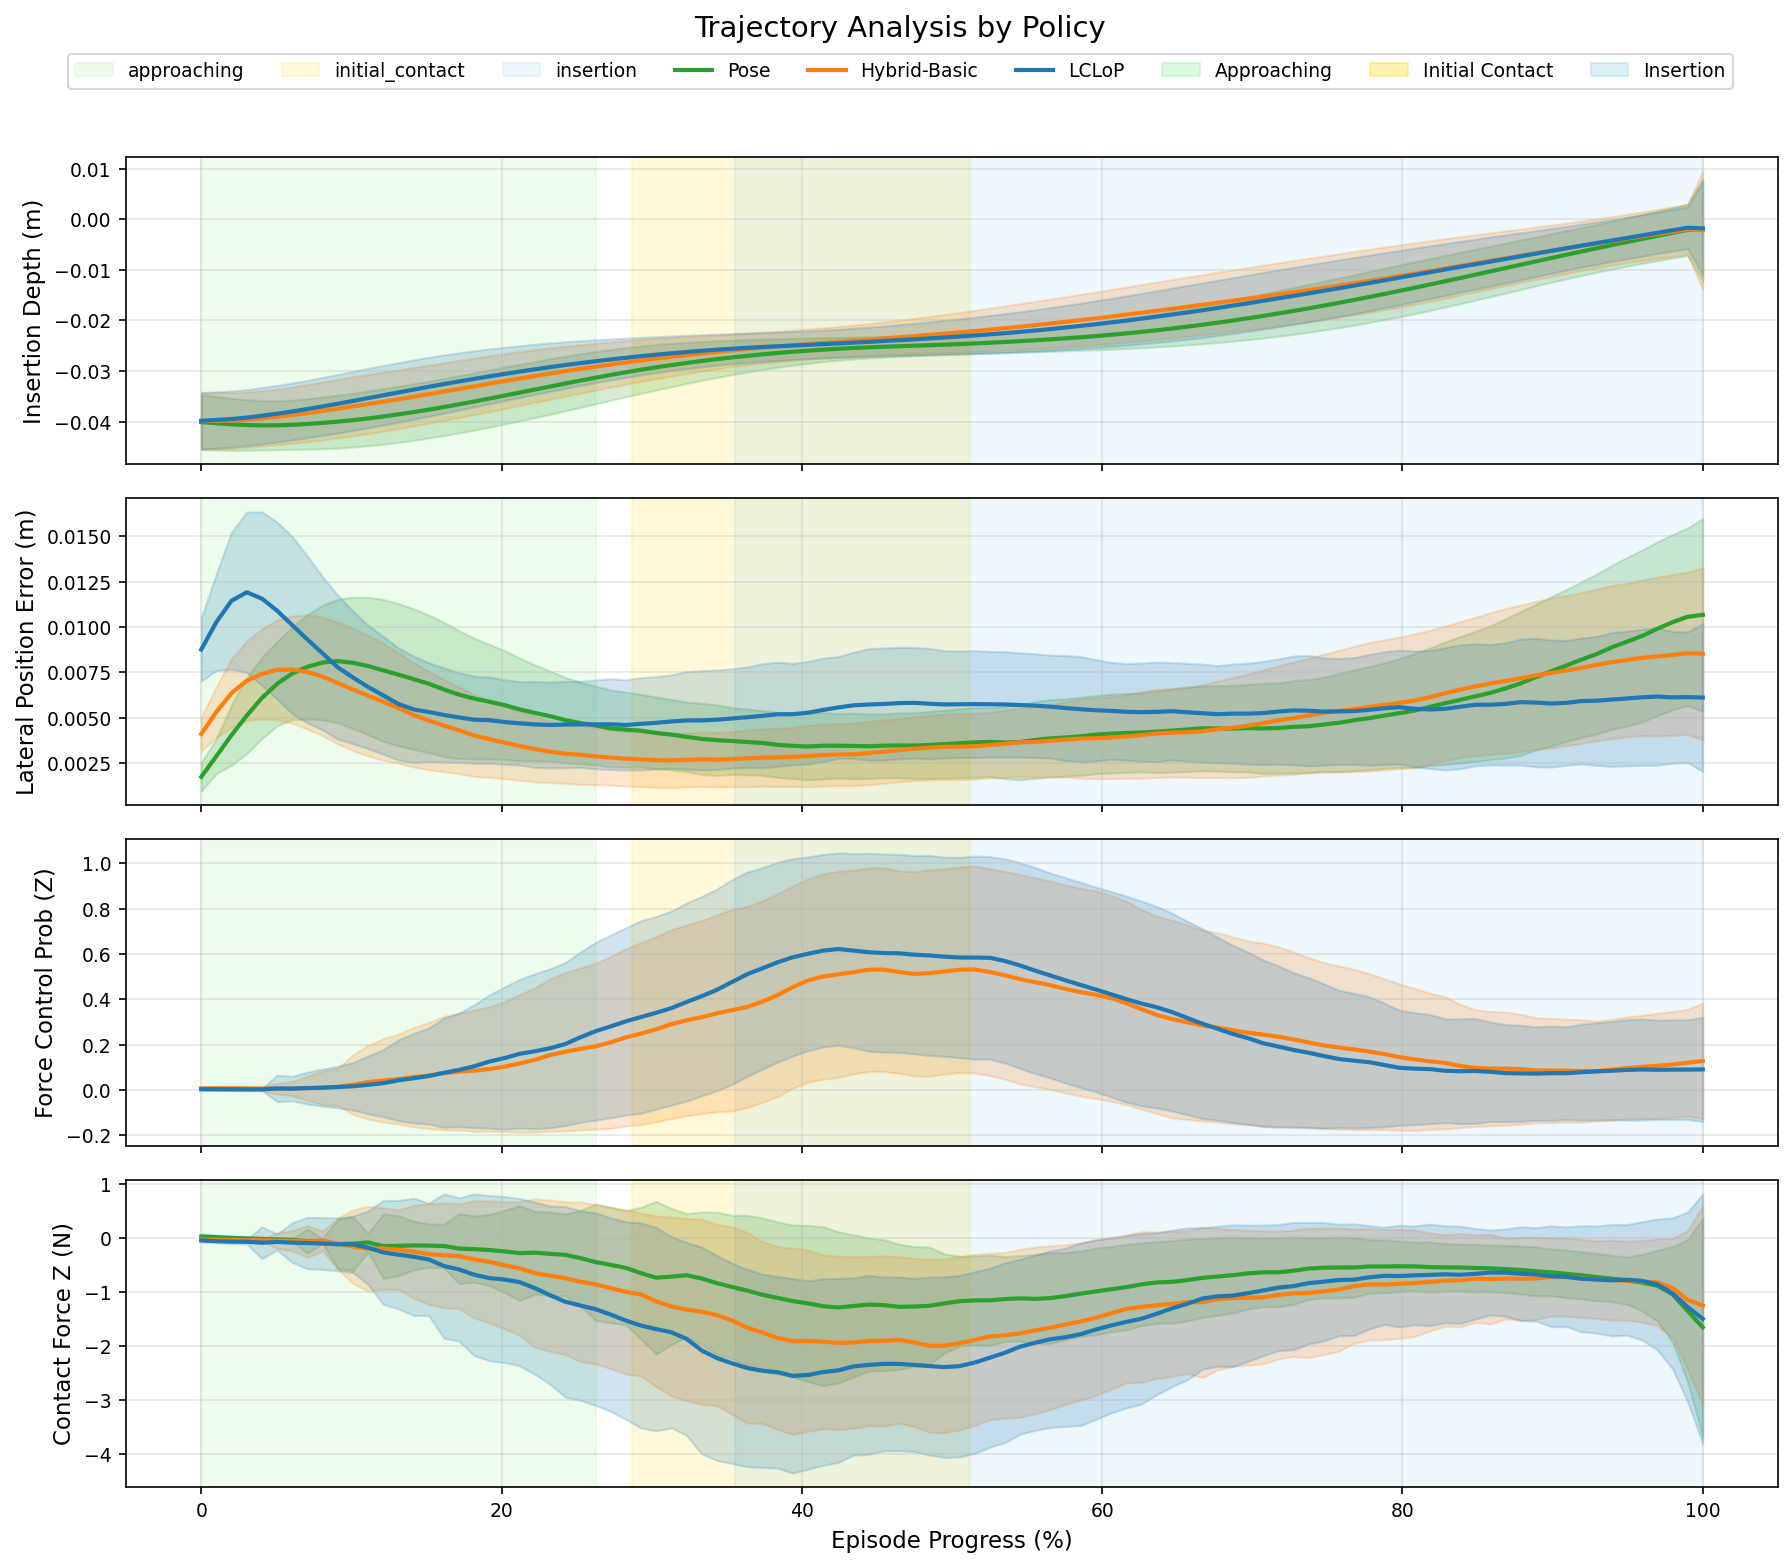

In [6]:
# ============================================================
# BLOCK 5: MULTI-PANEL TRAJECTORY PLOT
# ============================================================
#
# Generates a multi-panel figure showing:
# - Row 1: Z position (insertion depth) over time
# - Row 2: Lateral error (XY plane) over time
# - Row 3: Force control probability (Z-axis) over time
# - Row 4: Contact force magnitude over time
#
# Each panel shows mean ± std across episodes, with phase backgrounds.

# Plot Configuration
FIGSIZE = (12, 10)
DPI = 150
NORMALIZE_TIME = True  # Normalize to 0-100% episode completion
N_POINTS = 100  # Number of points for interpolation
ALPHA_FILL = 0.2  # Alpha for std fill

# Font sizes
FONT_TITLE = 14
FONT_AXIS_LABEL = 11
FONT_TICK = 9
FONT_LEGEND = 9

# Variables to plot
VARIABLES = [
    {'key': 'insertion_depth', 'label': 'Insertion Depth (m)', 'axis': None},
    {'key': 'position_error', 'label': 'Lateral Position Error (m)', 'axis': 'xy'},  # XY plane magnitude
    {'key': 'control_probability', 'label': 'Force Control Prob (Z)', 'axis': 2},  # Z-axis
    {'key': 'contact_force', 'label': 'Contact Force Z (N)', 'axis': 2},  # Z-axis
]

# ============================================================

def extract_variable(step: Dict, var_config: Dict) -> Optional[float]:
    """Extract a single value from a step based on variable config."""
    key = var_config['key']
    axis = var_config.get('axis')
    
    val = step.get(key)
    if val is None:
        return None
    
    if axis == 'xy':
        # XY plane magnitude
        if isinstance(val, (list, np.ndarray)) and len(val) >= 2:
            return np.sqrt(val[0]**2 + val[1]**2)
    elif axis is not None:
        # Specific axis
        if isinstance(val, (list, np.ndarray)) and len(val) > axis:
            return val[axis]
    else:
        # Scalar or first element
        if isinstance(val, (list, np.ndarray)):
            return val[0] if len(val) > 0 else None
        return val
    
    return None


def compute_phase_boundaries(episode_data: List[Dict], normalize: bool = True) -> Dict[str, Tuple[float, float]]:
    """
    Compute average phase boundaries across all episodes.
    
    Returns:
        Dict mapping phase name to (start, end) in normalized or step units.
    """
    phase_starts = defaultdict(list)
    phase_ends = defaultdict(list)
    
    for ep in episode_data:
        steps = ep['steps']
        if not steps:
            continue
        
        n_steps = len(steps)
        current_phase = None
        phase_start_idx = 0
        
        for i, step in enumerate(steps):
            phase = step.get('phase', 'unknown')
            if phase != current_phase:
                if current_phase is not None:
                    # Record end of previous phase
                    end = i / n_steps * 100 if normalize else i
                    phase_ends[current_phase].append(end)
                # Record start of new phase
                start = i / n_steps * 100 if normalize else i
                phase_starts[phase].append(start)
                current_phase = phase
        
        # Record end of final phase
        if current_phase is not None:
            end = 100 if normalize else n_steps
            phase_ends[current_phase].append(end)
    
    # Compute mean boundaries
    boundaries = {}
    for phase in PHASES:
        if phase in phase_starts and phase in phase_ends:
            boundaries[phase] = (
                np.mean(phase_starts[phase]),
                np.mean(phase_ends[phase])
            )
    
    return boundaries


def plot_trajectory_multipanel(
    episode_data: List[Dict],
    variables: List[Dict],
    normalize_time: bool = True,
    n_points: int = 100,
    split_by_outcome: bool = False,
    figsize: Tuple[float, float] = (12, 10)
) -> plt.Figure:
    """
    Create multi-panel trajectory plot with phase backgrounds.
    """
    n_vars = len(variables)
    fig, axes = plt.subplots(n_vars, 1, figsize=figsize, dpi=DPI, sharex=True)
    if n_vars == 1:
        axes = [axes]
    
    # Compute phase boundaries
    phase_boundaries = compute_phase_boundaries(episode_data, normalize=normalize_time)
    
    # Group episodes by policy
    episodes_by_policy = defaultdict(list)
    for ep in episode_data:
        episodes_by_policy[ep['policy']].append(ep)
    
    # Time axis
    if normalize_time:
        t = np.linspace(0, 100, n_points)
        xlabel = 'Episode Progress (%)'
    else:
        max_steps = max(len(ep['steps']) for ep in episode_data)
        t = np.arange(max_steps)
        xlabel = 'Step'
    
    for ax_idx, var_config in enumerate(variables):
        ax = axes[ax_idx]
        
        # Draw phase backgrounds
        for phase, (start, end) in phase_boundaries.items():
            if phase in PHASE_COLORS:
                ax.axvspan(start, end, alpha=0.15, color=PHASE_COLORS[phase], label=phase if ax_idx == 0 else None)
        
        # Plot each policy
        for policy, eps in episodes_by_policy.items():
            trajectories = []
            
            for ep in eps:
                values = []
                for step in ep['steps']:
                    val = extract_variable(step, var_config)
                    values.append(val if val is not None else np.nan)
                
                if normalize_time and len(values) > 1:
                    # Interpolate to fixed number of points
                    t_orig = np.linspace(0, 100, len(values))
                    interpolated = np.interp(t, t_orig, values)
                    trajectories.append(interpolated)
                elif not normalize_time:
                    # Pad with NaN
                    padded = np.full(len(t), np.nan)
                    padded[:len(values)] = values
                    trajectories.append(padded)
            
            if trajectories:
                trajectories = np.array(trajectories)
                with np.errstate(all='ignore'):
                    mean = np.nanmean(trajectories, axis=0)
                    std = np.nanstd(trajectories, axis=0)
                
                color = METHOD_COLORS.get(policy, 'gray')
                ax.plot(t, mean, color=color, linewidth=2, label=policy if ax_idx == 0 else None)
                ax.fill_between(t, mean - std, mean + std, color=color, alpha=ALPHA_FILL)
        
        ax.set_ylabel(var_config['label'], fontsize=FONT_AXIS_LABEL)
        ax.tick_params(labelsize=FONT_TICK)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel(xlabel, fontsize=FONT_AXIS_LABEL)
    
    # Create legend with both policies and phases
    handles, labels = axes[0].get_legend_handles_labels()
    # Add phase patches
    for phase in PHASES:
        if phase in phase_boundaries:
            handles.append(mpatches.Patch(color=PHASE_COLORS[phase], alpha=0.3))
            labels.append(phase.replace('_', ' ').title())
    
    fig.legend(handles, labels, loc='upper center', ncol=len(handles), fontsize=FONT_LEGEND,
               bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_trajectory_multipanel(
        all_episode_data,
        VARIABLES,
        normalize_time=NORMALIZE_TIME,
        n_points=N_POINTS,
        figsize=FIGSIZE
    )
    plt.suptitle('Trajectory Analysis by Policy', fontsize=FONT_TITLE, y=1.04)
    plt.show()
else:
    print("No episode data loaded. Please run trajectory evaluation first.")

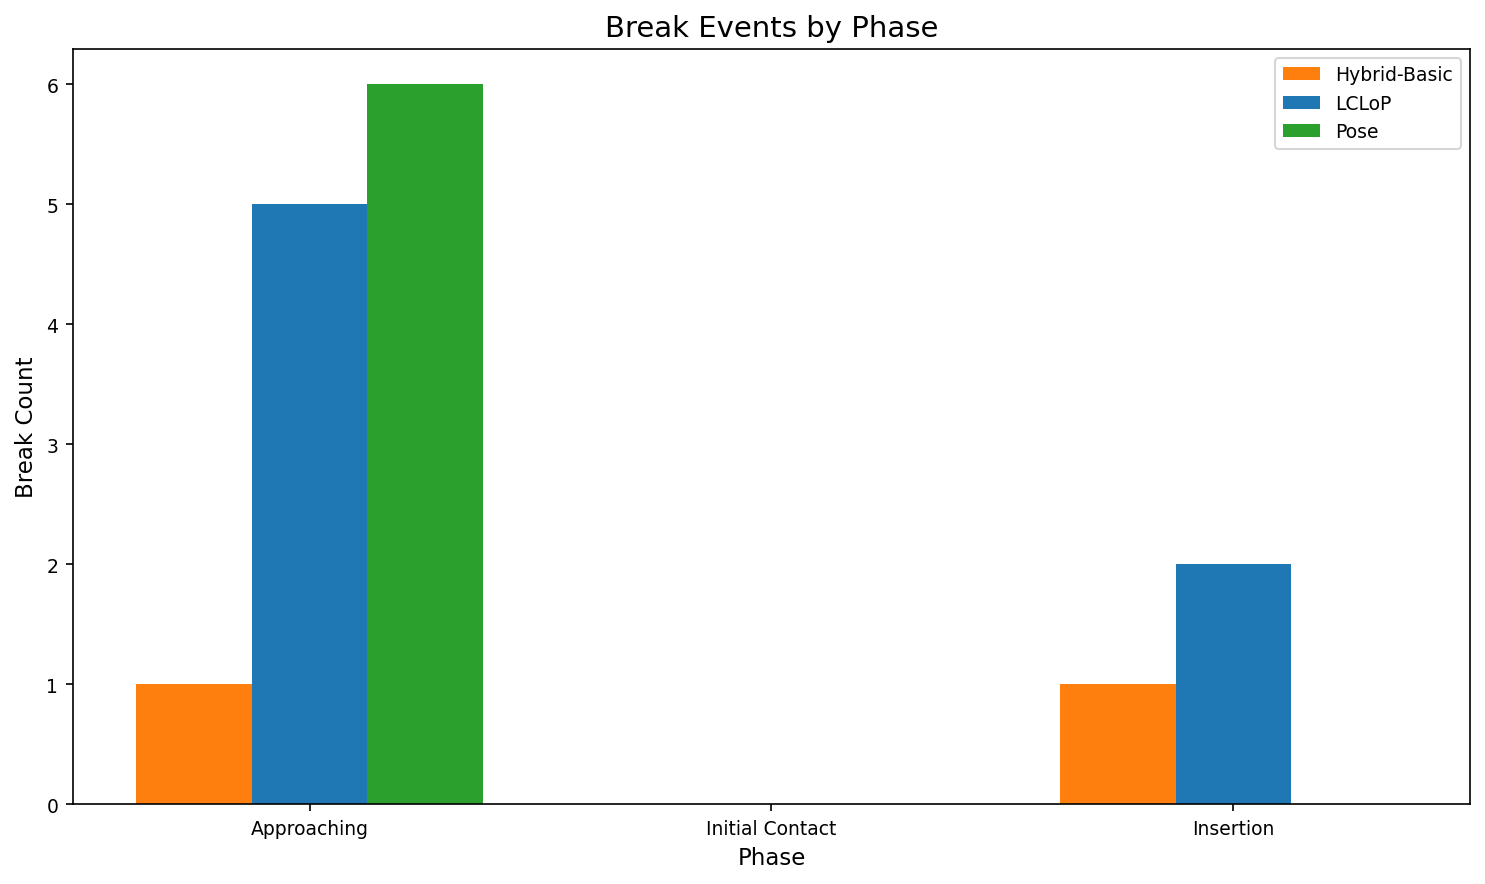

In [7]:
# ============================================================
# BLOCK 6: BREAKS BY PHASE
# ============================================================
#
# Bar chart showing the number of break events that occurred
# during each phase, grouped by policy.

# Plot Configuration
FIGSIZE_BREAKS = (10, 6)
BAR_WIDTH = 0.25

# ============================================================

def plot_break_count_by_phase(
    episode_data: List[Dict],
    figsize: Tuple[float, float] = (10, 6)
) -> plt.Figure:
    """
    Bar chart of break counts by phase, grouped by policy.
    """
    # Extract phase at termination for break episodes
    break_phases = defaultdict(lambda: defaultdict(int))
    
    for ep in episode_data:
        if ep['outcome'] == 'break':
            policy = ep['policy']
            # Find the last step (where break occurred)
            if ep['steps']:
                last_step = ep['steps'][-1]
                phase = last_step.get('phase', 'unknown')
                break_phases[policy][phase] += 1
    
    if not break_phases:
        print("No break events found in data.")
        return None
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    
    policies = sorted(break_phases.keys())
    x = np.arange(len(PHASES))
    width = BAR_WIDTH
    
    for i, policy in enumerate(policies):
        counts = [break_phases[policy][phase] for phase in PHASES]
        offset = (i - len(policies)/2 + 0.5) * width
        color = METHOD_COLORS.get(policy, 'gray')
        ax.bar(x + offset, counts, width, label=policy, color=color)
    
    ax.set_xlabel('Phase', fontsize=FONT_AXIS_LABEL)
    ax.set_ylabel('Break Count', fontsize=FONT_AXIS_LABEL)
    ax.set_title('Break Events by Phase', fontsize=FONT_TITLE)
    ax.set_xticks(x)
    ax.set_xticklabels([p.replace('_', ' ').title() for p in PHASES], fontsize=FONT_TICK)
    ax.legend(fontsize=FONT_LEGEND)
    ax.tick_params(labelsize=FONT_TICK)
    
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_break_count_by_phase(all_episode_data, figsize=FIGSIZE_BREAKS)
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

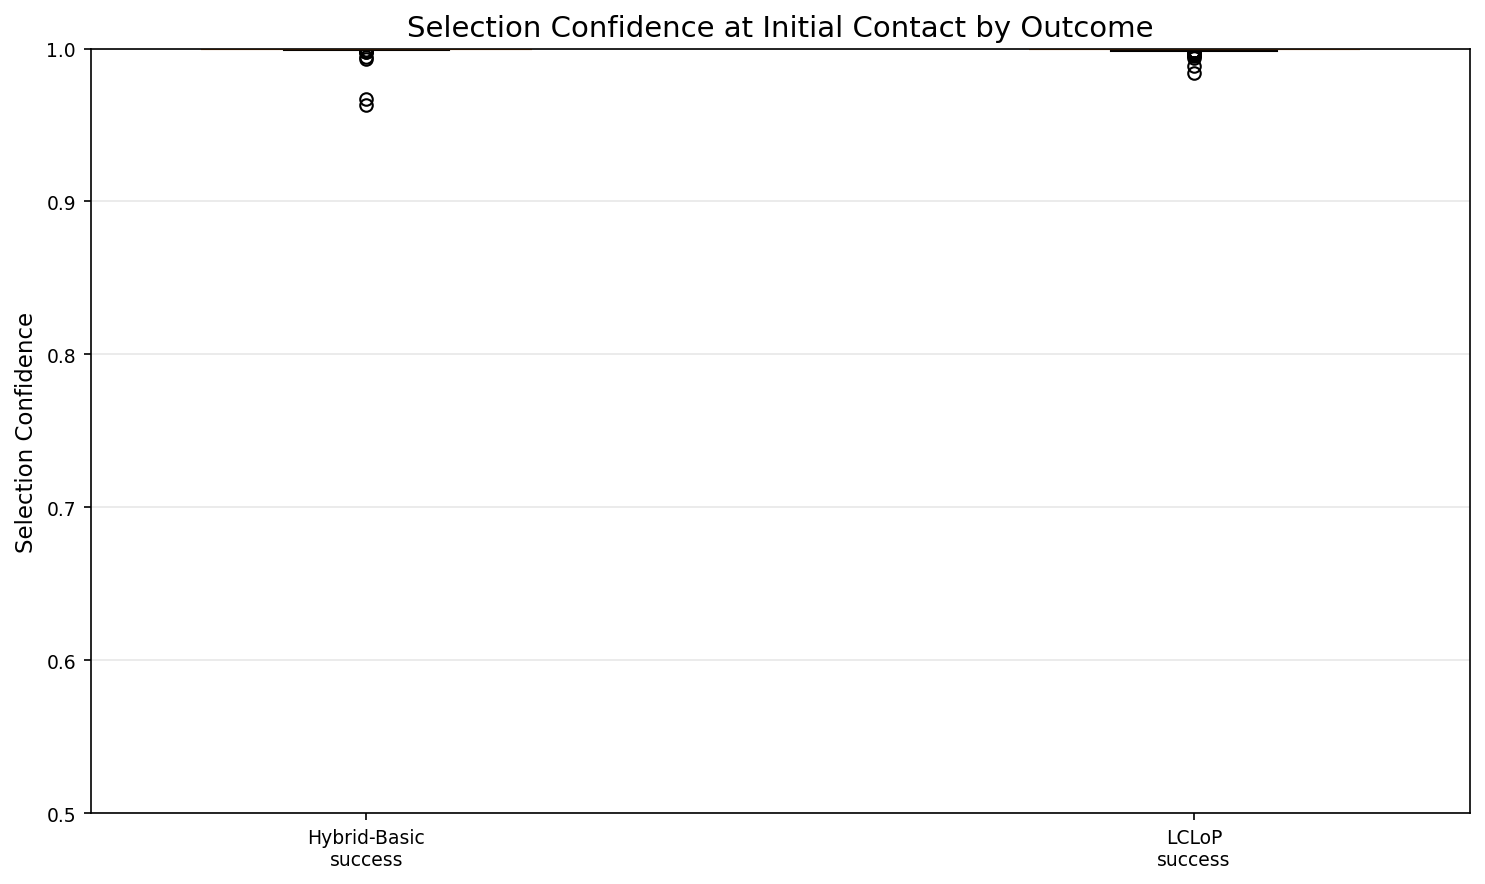

In [8]:
# ============================================================
# BLOCK 7: SELECTION CONFIDENCE COMPARISON
# ============================================================
#
# Compares selection confidence (max probability across modes)
# at the moment of initial contact, separated by outcome.
# Higher confidence may correlate with better outcomes.

# Plot Configuration
FIGSIZE_CONFIDENCE = (10, 6)
CONFIDENCE_AXIS = 2  # Z-axis for insertion

# ============================================================

def plot_selection_confidence_at_contact(
    episode_data: List[Dict],
    axis: int = 2,
    figsize: Tuple[float, float] = (10, 6)
) -> plt.Figure:
    """
    Box plot of selection confidence at initial contact, by outcome.
    
    Selection confidence = max(p, 1-p) where p is the selection probability.
    This measures how "certain" the policy is about its mode choice.
    """
    # Collect confidence at contact for each policy and outcome
    data = defaultdict(lambda: defaultdict(list))
    
    for ep in episode_data:
        policy = ep['policy']
        outcome = ep['outcome']
        
        # Find first step in initial_contact phase
        for step in ep['steps']:
            if step.get('phase') == 'initial_contact':
                prob = step.get('control_probability')
                if prob is not None and len(prob) > axis:
                    p = prob[axis]
                    confidence = max(p, 1 - p)
                    data[policy][outcome].append(confidence)
                break
    
    if not data:
        print("No selection confidence data found.")
        return None
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    
    policies = sorted(data.keys())
    outcomes_present = ['success', 'break']  # Focus on these
    
    positions = []
    labels = []
    box_data = []
    colors = []
    
    pos = 0
    for policy in policies:
        for outcome in outcomes_present:
            if data[policy][outcome]:
                box_data.append(data[policy][outcome])
                positions.append(pos)
                labels.append(f"{policy}\n{outcome}")
                colors.append(METHOD_COLORS.get(policy, 'gray'))
                pos += 1
        pos += 0.5  # Gap between policies
    
    bp = ax.boxplot(box_data, positions=positions, patch_artist=True, widths=0.6)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=FONT_TICK)
    ax.set_ylabel('Selection Confidence', fontsize=FONT_AXIS_LABEL)
    ax.set_title('Selection Confidence at Initial Contact by Outcome', fontsize=FONT_TITLE)
    ax.set_ylim(0.5, 1.0)  # Confidence ranges from 0.5 to 1.0
    ax.tick_params(labelsize=FONT_TICK)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_selection_confidence_at_contact(
        all_episode_data,
        axis=CONFIDENCE_AXIS,
        figsize=FIGSIZE_CONFIDENCE
    )
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

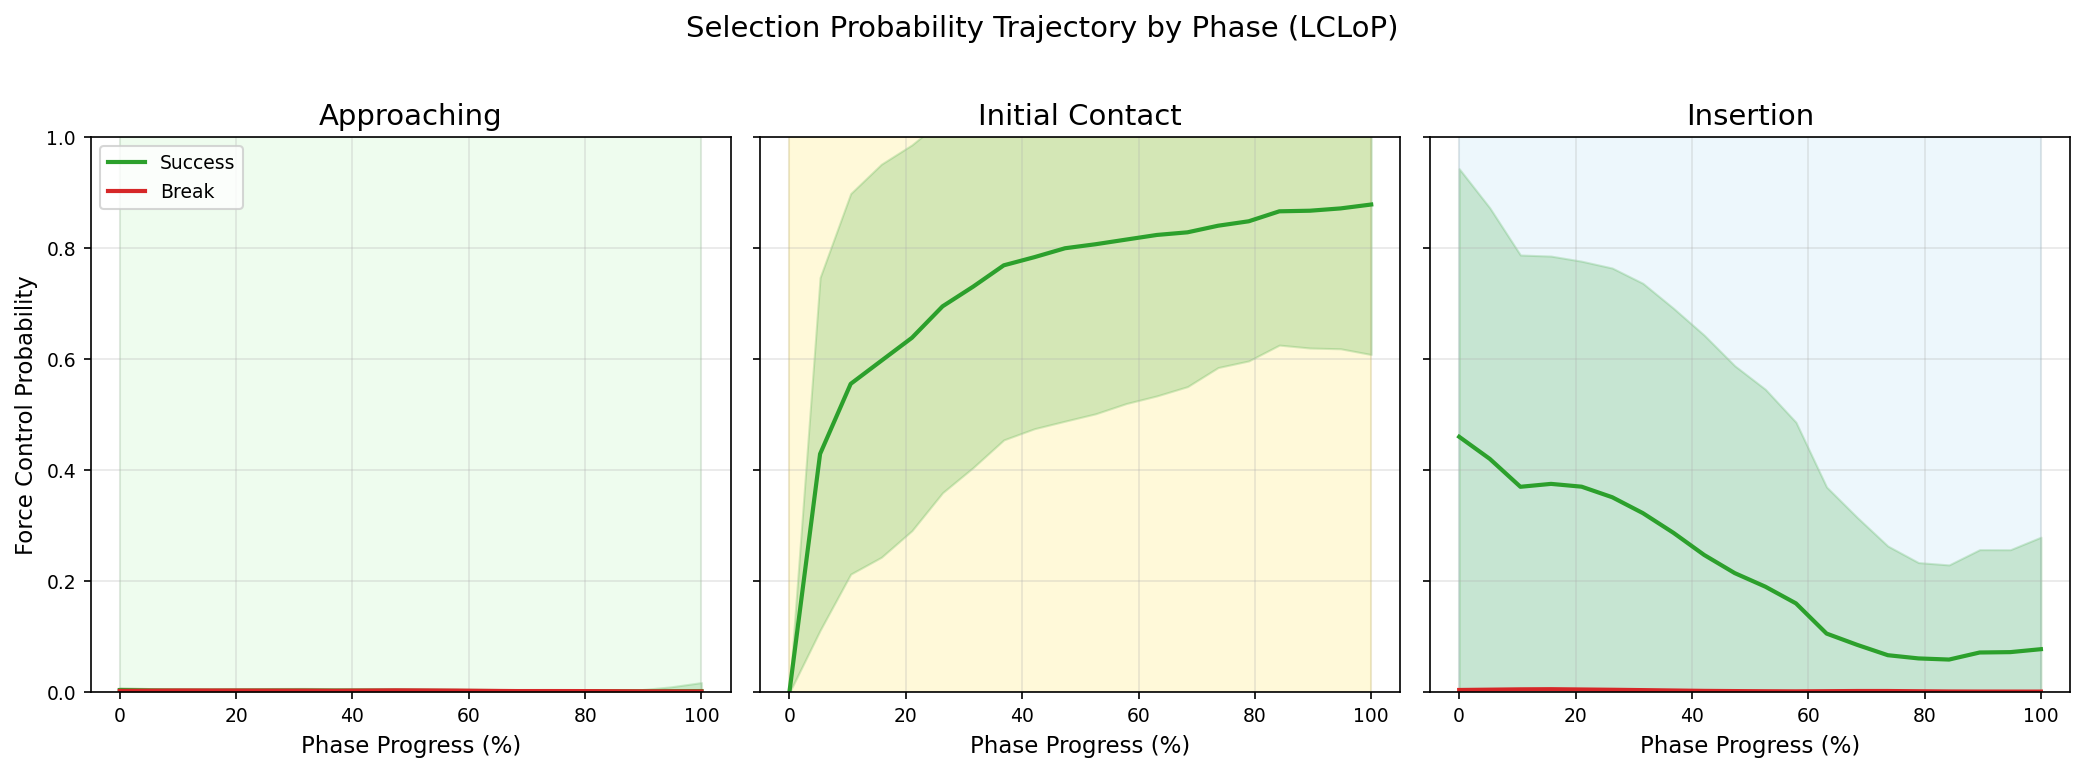

In [9]:
# ============================================================
# BLOCK 8: SELECTION PROBABILITY TRAJECTORIES BY PHASE
# ============================================================
#
# Shows how selection probability (force vs position control)
# evolves within each phase, separated by outcome.

# Plot Configuration
FIGSIZE_PROB_TRAJ = (14, 5)
PROB_AXIS = 2  # Z-axis
NUM_BINS = 20  # Normalized time bins per phase

# Outcome colors
OUTCOME_COLORS = {
    'success': '#2ca02c',  # Green
    'break': '#d62728',    # Red
    'timeout': '#7f7f7f',  # Gray
}

# ============================================================

def plot_selection_probability_by_phase_trajectory(
    episode_data: List[Dict],
    axis: int = 2,
    num_bins: int = 20,
    figsize: Tuple[float, float] = (14, 5)
) -> plt.Figure:
    """
    Plot selection probability trajectories normalized within each phase.
    Shows mean ± std for success vs break outcomes.
    """
    # Filter to LCLoP only (only policy with meaningful selection probability)
    lclop_episodes = [ep for ep in episode_data if ep['policy'] == 'LCLoP']
    
    if not lclop_episodes:
        print("No LCLoP episodes found. Selection probability only applies to LCLoP.")
        return None
    
    # Collect trajectories: {phase: {outcome: [[prob_at_normalized_time]]}}
    trajectories = {phase: {outcome: [] for outcome in ['success', 'break']} for phase in PHASES}
    
    for ep in lclop_episodes:
        outcome = ep['outcome']
        if outcome not in ['success', 'break']:
            continue
        
        # Group steps by phase
        phase_steps = defaultdict(list)
        for step in ep['steps']:
            phase_steps[step.get('phase', 'unknown')].append(step)
        
        # Extract normalized trajectory for each phase
        for phase in PHASES:
            steps = phase_steps.get(phase, [])
            if len(steps) < 2:
                continue
            
            probs = []
            for step in steps:
                prob = step.get('control_probability')
                if prob is not None and len(prob) > axis:
                    probs.append(prob[axis])
                else:
                    probs.append(np.nan)
            
            # Interpolate to fixed number of bins
            t_orig = np.linspace(0, 1, len(probs))
            t_new = np.linspace(0, 1, num_bins)
            normalized = np.interp(t_new, t_orig, probs)
            trajectories[phase][outcome].append(normalized)
    
    # Create plot
    fig, axes = plt.subplots(1, len(PHASES), figsize=figsize, dpi=DPI, sharey=True)
    
    t_norm = np.linspace(0, 100, num_bins)
    
    for idx, phase in enumerate(PHASES):
        ax = axes[idx]
        
        # Add phase background
        ax.axvspan(0, 100, alpha=0.15, color=PHASE_COLORS[phase])
        
        for outcome in ['success', 'break']:
            trajs = trajectories[phase][outcome]
            if not trajs:
                continue
            
            trajs = np.array(trajs)
            with np.errstate(all='ignore'):
                mean = np.nanmean(trajs, axis=0)
                std = np.nanstd(trajs, axis=0)
            
            color = OUTCOME_COLORS[outcome]
            ax.plot(t_norm, mean, color=color, linewidth=2, label=outcome.title())
            ax.fill_between(t_norm, mean - std, mean + std, color=color, alpha=ALPHA_FILL)
        
        ax.set_xlabel('Phase Progress (%)', fontsize=FONT_AXIS_LABEL)
        ax.set_title(phase.replace('_', ' ').title(), fontsize=FONT_TITLE)
        ax.tick_params(labelsize=FONT_TICK)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
        
        if idx == 0:
            ax.set_ylabel('Force Control Probability', fontsize=FONT_AXIS_LABEL)
            ax.legend(fontsize=FONT_LEGEND, loc='upper left')
    
    plt.suptitle('Selection Probability Trajectory by Phase (LCLoP)', fontsize=FONT_TITLE, y=1.02)
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_selection_probability_by_phase_trajectory(
        all_episode_data,
        axis=PROB_AXIS,
        num_bins=NUM_BINS,
        figsize=FIGSIZE_PROB_TRAJ
    )
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

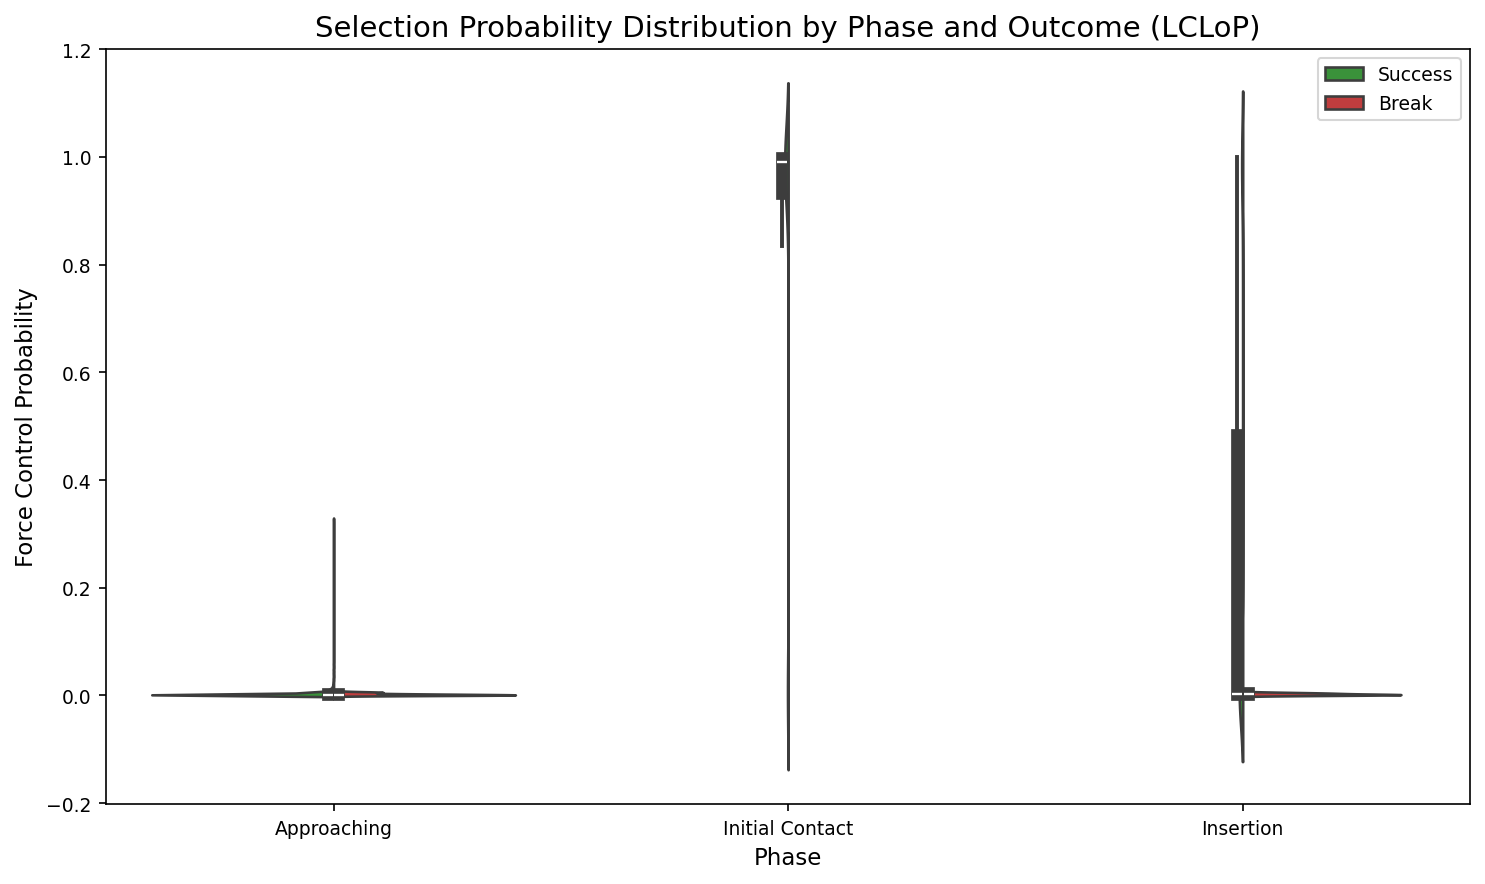

In [10]:
# ============================================================
# BLOCK 9: SELECTION PROBABILITY BY PHASE (VIOLIN PLOT)
# ============================================================
#
# Violin plots showing distribution of selection probability
# values within each phase, comparing success vs break outcomes.

# Plot Configuration
FIGSIZE_VIOLIN = (10, 6)

# ============================================================

def plot_selection_probability_by_phase_violin(
    episode_data: List[Dict],
    axis: int = 2,
    figsize: Tuple[float, float] = (10, 6)
) -> plt.Figure:
    """
    Violin plots of selection probability by phase, comparing outcomes.
    """
    import seaborn as sns
    
    # Filter to LCLoP only
    lclop_episodes = [ep for ep in episode_data if ep['policy'] == 'LCLoP']
    
    if not lclop_episodes:
        print("No LCLoP episodes found.")
        return None
    
    # Collect data
    data = defaultdict(lambda: defaultdict(list))
    
    for ep in lclop_episodes:
        outcome = ep['outcome']
        if outcome not in ['success', 'break']:
            continue
        
        for step in ep['steps']:
            phase = step.get('phase', 'unknown')
            prob = step.get('control_probability')
            if prob is not None and len(prob) > axis and phase in PHASES:
                data[phase][outcome].append(prob[axis])
    
    # Build DataFrame
    rows = []
    for phase in PHASES:
        for outcome in ['success', 'break']:
            for prob in data[phase][outcome]:
                rows.append({
                    'Phase': phase.replace('_', ' ').title(),
                    'Outcome': outcome.title(),
                    'Probability': prob
                })
    
    if not rows:
        print("No data to plot.")
        return None
    
    df = pd.DataFrame(rows)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    
    phase_order = [p.replace('_', ' ').title() for p in PHASES]
    
    sns.violinplot(
        data=df, x='Phase', y='Probability', hue='Outcome',
        order=phase_order, split=True, ax=ax,
        palette={'Success': OUTCOME_COLORS['success'], 'Break': OUTCOME_COLORS['break']}
    )
    
    ax.set_xlabel('Phase', fontsize=FONT_AXIS_LABEL)
    ax.set_ylabel('Force Control Probability', fontsize=FONT_AXIS_LABEL)
    ax.set_title('Selection Probability Distribution by Phase and Outcome (LCLoP)', fontsize=FONT_TITLE)
    ax.tick_params(labelsize=FONT_TICK)
    ax.legend(fontsize=FONT_LEGEND)
    
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    try:
        fig = plot_selection_probability_by_phase_violin(
            all_episode_data,
            axis=PROB_AXIS,
            figsize=FIGSIZE_VIOLIN
        )
        if fig:
            plt.show()
    except ImportError:
        print("Seaborn not installed. Install with: pip install seaborn")
else:
    print("No episode data loaded.")

In [ ]:
# ============================================================
# BLOCK 10: SAVE ALL FIGURES
# ============================================================

# Output Configuration
OUTPUT_DIR = "./figures"
SAVE_FORMAT = "png"  # png, pdf, svg
SAVE_DPI = 300

# Figure definitions: (filename, plot_function, args)
FIGURES_TO_SAVE = [
    ('trajectory_multipanel', plot_trajectory_multipanel, 
     {'episode_data': all_episode_data, 'variables': VARIABLES, 
      'normalize_time': True, 'n_points': 100}),
    ('break_by_phase', plot_break_count_by_phase, 
     {'episode_data': all_episode_data}),
    ('selection_confidence', plot_selection_confidence_at_contact, 
     {'episode_data': all_episode_data, 'axis': 2}),
    ('selection_prob_trajectory', plot_selection_probability_by_phase_trajectory, 
     {'episode_data': all_episode_data, 'axis': 2, 'num_bins': 20}),
]

# ============================================================

SAVE_FIGURES = False  # Set to True to save figures

if SAVE_FIGURES and all_episode_data:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    for filename, plot_func, kwargs in FIGURES_TO_SAVE:
        try:
            fig = plot_func(**kwargs)
            if fig is not None:
                filepath = os.path.join(OUTPUT_DIR, f"{filename}.{SAVE_FORMAT}")
                fig.savefig(filepath, dpi=SAVE_DPI, bbox_inches='tight')
                print(f"Saved: {filepath}")
                plt.close(fig)
        except Exception as e:
            print(f"Error saving {filename}: {e}")
    
    print(f"\nAll figures saved to: {OUTPUT_DIR}")
else:
    print("Set SAVE_FIGURES = True to save figures to disk.")